# Transfer Learning using EfficientNetB4 - Image Augmentation

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

In [2]:
data_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Training and Validation')
test_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Testing')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1520


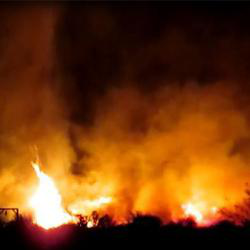

In [5]:
fire = list(data_dir.glob('fire/*'))
img = PIL.Image.open(str(fire[0]))
display(img)

### Load data into a tf dataset

Image input size: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [9]:
batch_size = 32
img_height = 224
img_width = 224
# Validation split 80/20
training_gen = ImageDataGenerator(horizontal_flip=True,
                                  vertical_flip=True,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  brightness_range = (0.75, 1.25),
                                  validation_split=0.2,
                                  rotation_range = 30)


train_ds = training_gen.flow_from_directory(data_dir, 
                                            target_size=(img_height, img_width), 
                                            color_mode = 'rgb',
                                            class_mode='binary',
                                            batch_size=batch_size,
                                            subset='training')

val_ds = training_gen.flow_from_directory(data_dir,
                                            target_size=(img_height, img_width),
                                            color_mode='rgb',
                                            class_mode = 'binary',
                                            batch_size=batch_size,
                                            subset='validation')

Found 1216 images belonging to 2 classes.
Found 304 images belonging to 2 classes.


## Seeing what augmentation is applied

In [11]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [12]:
img = load_img(f'{data_dir}/fire/fire_0132.jpg')

<Figure size 1800x1800 with 0 Axes>

<Figure size 1800x1800 with 0 Axes>

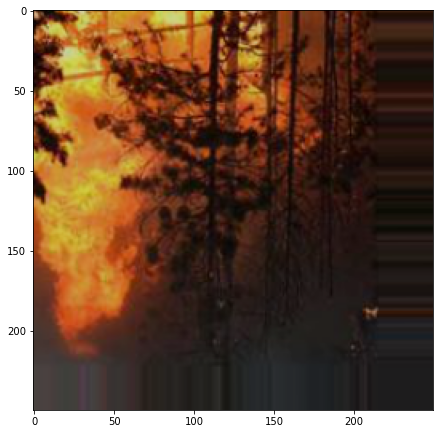

In [13]:
from matplotlib import pyplot

data = img_to_array(img)
samples = expand_dims(data, 0)
it = training_gen.flow(samples, batch_size=1)


# generate samples and plot
for i in range(3):
	# define subplot
	pyplot.figure(figsize=(25,25))
pyplot.subplot(330 + 1+i)
	# generate batch of images
batch = it.next()
	# convert to unsigned integers for viewing
image = batch[0].astype('uint8')
	# plot raw pixel data
pyplot.imshow(image)
# show the figure

pyplot.show()

### Get Class Names

In [15]:
class_names = list(train_ds.class_indices.keys())
print(class_names)

['fire', 'nofire']


### Create the base model from pre-trained convnets

In [19]:
## By specifying "include_top=False" argument you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction
IMG_SHAPE = (img_width, img_height) + (3,)
base_model = tf.keras.applications.EfficientNetB4(    
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
    classifier_activation="softmax")

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2022-04-22 17:07:08.788425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 17:07:08.788661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 17:07:08.788722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-22 17:07:08.788769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-22 17:07:08.788813: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

(32, 7, 7, 1792)


## Feature Extraction

In [20]:
base_model.trainable = False
base_model.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 112, 112, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 112, 112, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 113, 113, 14  0          ['block2a_expand_activation[0][0]
 g2D)                           4)                               ']                               
                                                                                                  
 block2a_d

 block2c_dwconv (DepthwiseConv2  (None, 56, 56, 192)  1728       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 56, 56, 192)  768        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 56, 56, 192)  0          ['block2c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePoolin

                                                                                                  
 block3a_bn (BatchNormalization  (None, 28, 28, 192)  768        ['block3a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3a_activation (Activation  (None, 28, 28, 192)  0          ['block3a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3a_se_squeeze (GlobalAver  (None, 192)         0           ['block3a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3a_s

 block3c_se_reshape (Reshape)   (None, 1, 1, 336)    0           ['block3c_se_squeeze[0][0]']     
                                                                                                  
 block3c_se_reduce (Conv2D)     (None, 1, 1, 14)     4718        ['block3c_se_reshape[0][0]']     
                                                                                                  
 block3c_se_expand (Conv2D)     (None, 1, 1, 336)    5040        ['block3c_se_reduce[0][0]']      
                                                                                                  
 block3c_se_excite (Multiply)   (None, 28, 28, 336)  0           ['block3c_activation[0][0]',     
                                                                  'block3c_se_expand[0][0]']      
                                                                                                  
 block3c_project_conv (Conv2D)  (None, 28, 28, 56)   18816       ['block3c_se_excite[0][0]']      
          

 block4a_se_reduce (Conv2D)     (None, 1, 1, 14)     4718        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 336)    5040        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 14, 14, 336)  0           ['block4a_activation[0][0]',     
                                                                  'block4a_se_expand[0][0]']      
                                                                                                  
 block4a_project_conv (Conv2D)  (None, 14, 14, 112)  37632       ['block4a_se_excite[0][0]']      
                                                                                                  
 block4a_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block4a_project_conv[0][0]']   
 lization)

 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 14, 14, 112)  0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 14, 14, 112)  0           ['block4c_drop[0][0]',           
                                                                  'block4b_add[0][0]']            
                                                                                                  
 block4d_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block4c_add[0][0]']            
                                                                                                  
 block4d_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block4d_expand_conv[0][0]']    
 ization) 

                                                                  'block4d_add[0][0]']            
                                                                                                  
 block4f_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block4e_add[0][0]']            
                                                                                                  
 block4f_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block4f_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4f_expand_activation (Act  (None, 14, 14, 672)  0          ['block4f_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4f_d

 block5b_dwconv (DepthwiseConv2  (None, 14, 14, 960)  24000      ['block5b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 14, 14, 960)  3840       ['block5b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5b_activation (Activation  (None, 14, 14, 960)  0          ['block5b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5b_se_squeeze (GlobalAver  (None, 960)         0           ['block5b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5d_activation (Activation  (None, 14, 14, 960)  0          ['block5d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 960)         0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5d_se_squeeze[0][0]']     
                                                                                                  
 block5d_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5d_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block5f_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5f_se_squeeze[0][0]']     
                                                                                                  
 block5f_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5f_se_reshape[0][0]']     
                                                                                                  
 block5f_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5f_se_reduce[0][0]']      
                                                                                                  
 block5f_se_excite (Multiply)   (None, 14, 14, 960)  0           ['block5f_activation[0][0]',     
                                                                  'block5f_se_expand[0][0]']      
          

                                                                                                  
 block6b_se_excite (Multiply)   (None, 7, 7, 1632)   0           ['block6b_activation[0][0]',     
                                                                  'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_project_conv (Conv2D)  (None, 7, 7, 272)    443904      ['block6b_se_excite[0][0]']      
                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 272)   1088        ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 272)    0           ['block6b_project_bn[0][0]']     
          

                                                                                                  
 block6d_project_bn (BatchNorma  (None, 7, 7, 272)   1088        ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_drop (Dropout)         (None, 7, 7, 272)    0           ['block6d_project_bn[0][0]']     
                                                                                                  
 block6d_add (Add)              (None, 7, 7, 272)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block6e_expand_conv (Conv2D)   (None, 7, 7, 1632)   443904      ['block6d_add[0][0]']            
          

                                                                                                  
 block6f_add (Add)              (None, 7, 7, 272)    0           ['block6f_drop[0][0]',           
                                                                  'block6e_add[0][0]']            
                                                                                                  
 block6g_expand_conv (Conv2D)   (None, 7, 7, 1632)   443904      ['block6f_add[0][0]']            
                                                                                                  
 block6g_expand_bn (BatchNormal  (None, 7, 7, 1632)  6528        ['block6g_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6g_expand_activation (Act  (None, 7, 7, 1632)  0           ['block6g_expand_bn[0][0]']      
 ivation) 

                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1632)  6528        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1632)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 7, 7, 1632)  14688       ['block7a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7a_b

## Add classification head

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1792)


In [22]:
prediction_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Chain together the model

In [24]:
inputs = tf.keras.Input(shape = (IMG_SHAPE))
x = base_model(inputs, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [25]:
# Useful metrics paper:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=(True)),
              metrics = [tf.keras.metrics.Precision(name = "precision"),
                         tf.keras.metrics.Recall(name = "recall"),
                         tf.keras.metrics.AUC(name = "auc")]
             )

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 1,793
Non-trainable params: 17,673,823
_____________________________________________

## Train the model

In [27]:
# Tests the initial base model
initial_epochs = 10
loss0, precision0, recall0, auc0 = model.evaluate(val_ds)

/home/charlie/miniconda3/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 18s 2s/step - loss: 0.6681 - precision: 0.6571 - recall: 0.4539 - auc: 0.6547


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial precision: {:.2f}".format(precision0))
print("initial recall: {:.2f}".format(recall0))
print("initial auc: {:.2f}".format(auc0))

initial loss: 0.67
initial precision: 0.66
initial recall: 0.45
initial auc: 0.65


In [29]:
history = model.fit(train_ds,                    
                    epochs = initial_epochs,                    
                    validation_data = val_ds)

Epoch 1/10
38/38 [==============================] - 88s 2s/step - loss: 0.6333 - precision: 0.7593 - recall: 0.4359 - auc: 0.7614 - val_loss: 0.5847 - val_precision: 0.8071 - val_recall: 0.7434 - val_auc: 0.8797
Epoch 2/10
38/38 [==============================] - 82s 2s/step - loss: 0.5485 - precision: 0.8455 - recall: 0.7829 - auc: 0.9085 - val_loss: 0.5290 - val_precision: 0.8452 - val_recall: 0.8618 - val_auc: 0.9345
Epoch 3/10
38/38 [==============================] - 83s 2s/step - loss: 0.4802 - precision: 0.9015 - recall: 0.9030 - auc: 0.9567 - val_loss: 0.4536 - val_precision: 0.8667 - val_recall: 0.9408 - val_auc: 0.9786
Epoch 4/10
38/38 [==============================] - 83s 2s/step - loss: 0.4142 - precision: 0.9179 - recall: 0.9375 - auc: 0.9805 - val_loss: 0.4178 - val_precision: 0.9295 - val_recall: 0.9539 - val_auc: 0.9882
Epoch 5/10
38/38 [==============================] - 84s 2s/step - loss: 0.3705 - precision: 0.9198 - recall: 0.9622 - auc: 0.9861 - val_loss: 0.3839 - v

### Learning Curves

Found 381 files belonging to 2 classes.


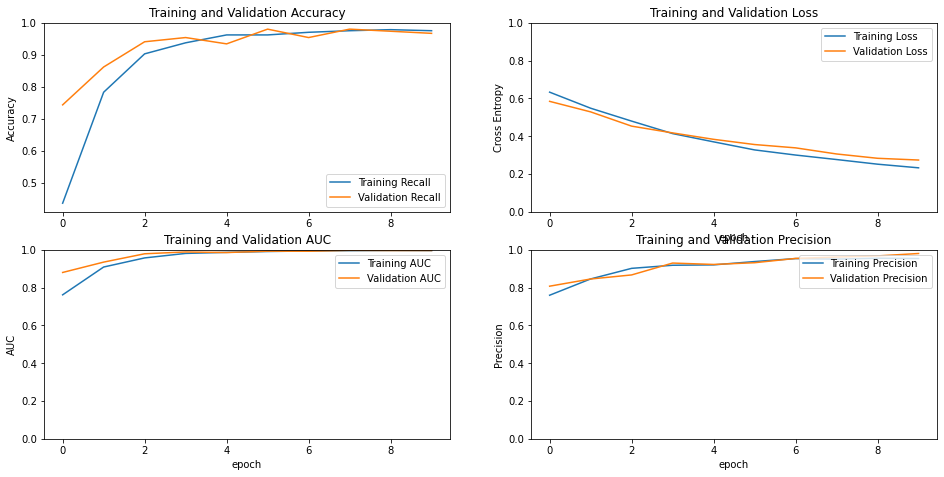

In [31]:
recall = history.history['recall']
val_recall = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

auc = history.history['auc']
val_auc = history.history['val_auc']

precision = history.history['precision']
val_pre = history.history['val_precision']

plt.figure(figsize = (16, 16))
plt.subplot(4, 2, 1)
plt.plot(recall, label = 'Training Recall')
plt.plot(val_recall, label='Validation Recall')

plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              shuffle = True,    
                                                              seed = 123,    
                                                              image_size = (img_height, img_width),
                                                              batch_size = batch_size
                                                             )

plt.subplot(4, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(4, 2, 3)
plt.plot(auc, label = 'Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('AUC')
plt.ylim([0,1.0])
plt.title('Training and Validation AUC')
plt.xlabel('epoch')

plt.subplot(4, 2, 4)
plt.plot(precision, label = 'Training Precision')
plt.plot(val_pre, label='Validation Precision')
plt.legend(loc='upper right')
plt.ylabel('Precision')
plt.ylim([0,1.0])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

In [32]:
# Previously the base model weights were not updated and only a few layers on top of the EfficientNetV2 was trained
# Unfreeze and train the top layers of the pre-trained model to fine tune to the dataset

## Un-freeze top layers of the model

base_model.trainable = True

In [33]:
# Let's take a look to see how many layers are in the base model#
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  474


In [34]:
# Fine-tune from this layer onwards

fine_tune_at = 250

# Freeze all the layers before the `fine_tune_at` layer

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### Compile the Model

In [35]:
## Important to use a lower training weight since using more layers, otherwise
# it could overfit very quickly 
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
              metrics = [tf.keras.metrics.Precision(name = "precision"),
                         tf.keras.metrics.Recall(name = "recall"),
                         tf.keras.metrics.AUC(name = "auc")])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 15,826,625
Non-trainable params: 1,848,991
_________________________________________

In [36]:
print(len(model.trainable_variables))

199


### Continue Training the Model

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = val_ds)

Epoch 10/20
11/38 [=======>......................] - ETA: 1:34 - loss: 0.1566 - precision: 0.9833 - recall: 0.9944 - auc: 0.9965

### Learning Curves

In [ ]:
recall += history_fine.history['recall']
val_recall += history_fine.history['val_recall']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

auc += history_fine.history['auc']
val_auc += history_fine.history['val_auc']

precision += history_fine.history['precision']
val_pre += history_fine.history['val_precision']

plt.figure(figsize = (16, 16))
plt.subplot(4, 2, 1)
plt.plot(recall, label = 'Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(),
         label='Start Fine Tuning')
plt.title('Training and Validation Recall')
plt.subplot(4, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), 
         label='Start Fine Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.subplot(4, 2, 3)
plt.plot(auc, label = 'Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('AUC')
plt.ylim([0.7,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), 
         label='Start Fine Tuning')
plt.title('Training and Validation AUC')
plt.xlabel('epoch')
plt.subplot(4, 2, 4)
plt.plot(precision, label = 'Training Precision')
plt.plot(val_pre, label='Validation Precision')
plt.legend(loc='upper right')
plt.ylabel('Precision')
plt.ylim([0.7,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(),
         label='Start Fine Tuning')
plt.title('Training and Validation Precision')
plt.xlabel('epoch')plt.show()

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              shuffle = True,
                                                              seed = 123,    
                                                              image_size = (img_height, img_width),
                                                              batch_size = batch_size    
                                                             )

## Verifying on test set

In [ ]:
loss, precision, recall, auc = model.evaluate(test_ds)
print('Test loss :', loss)
print('Test precision :', precision)
print('Test recall :', recall)
print('Test auc :', auc)

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
# pred = model.predict(test_ds)
# pred = np.argmax(pred, axis = 1)[:5]
# label = 

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)

In [ ]:
print(np.round(predictions, 3))

In [ ]:
predictions = tf.where(predictions < 0.5, 0, 1)
print(predictions)

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
# pred = model.predict(test_ds)
# pred = np.argmax(pred, axis = 1)[:5]
# label = 

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
print('Predictions:', predictions.numpy())
print('Labels:', label_batch)

plt.figure(figsize=(10, 10))

for i in range(9):  
    ax = plt.subplot(3, 3, i + 1)  
    plt.imshow(image_batch[i].astype("uint8"))  
    plt.title(class_names[predictions[i]])  
    plt.axis("off")

## Saving model

In [ ]:
model.save('models/IA_model00_EfficientNetB4.h5')

## Confusion Matrix

In [ ]:
import tensorflow as tf
import pathlib
import numpy as np
import functions

data_dir = pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Training and Validation')
test_dir = pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Testing')
loaded_model = tf.keras.models.load_model('models/IA_model00_EfficientNetB4.h5')

img_height, img_width, batch_size = [224, 224, 32]

test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              shuffle = True,
                                                              seed = 89787,
                                                              image_size = (img_height, img_width),
                                                              batch_size = batch_size,
                                                              labels = 'inferred',
                                                              label_mode = 'binary'
                                                             )
functions.ConfusionMatrix(loaded_model, test_ds)

In [ ]:
count = 0
for i in test_preds:
    if i>0.5:        
        print("no fire")
    else:
        count += 1
        print("fire")
print('Incorrectly predicted ', count,  ' out of ',len(test_preds), '. FPR: ', round(count/len(test_preds), 2))

In [ ]:
import tensorflow as tf
import functions

data_dir = '../../data/Alt_dataset/Training Dataset'
loaded_model = tf.keras.models.load_model('models/IA_model00_EfficientNetv3_Small.h5')

img_height, img_width, batch_size = [224, 224, 32] 

custom_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    seed = 89787,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    labels = 'inferred',
    label_mode = 'binary'
    )

## Check if images are in the right format

bad_file_list = functions.CheckImagesReport(data_dir)

In [ ]:
## Delete the incompatible files from the folder
functions.DeleteIncompatibleImages(bad_file_list)


In [ ]:
functions.ConfusionMatrix(loaded_model, custom_test_ds)

In [ ]:
loss, precision, recall, auc = loaded_model.evaluate(custom_test_ds)
print('Test loss :', loss)
print('Test precision :', precision)
print('Test recall :', recall)
print('Test auc :', auc)